In [14]:
from pathlib import Path
import pandas as pd
import numpy as np
import pyomo.environ as pyo
import os
import matplotlib.pyplot as plt
from pyomo.environ import ConcreteModel, Set, Param, Var, NonNegativeReals, Constraint, Objective, minimize, NonPositiveReals
from pyomo.opt import SolverFactory
from IPython.display import display



In [ ]:
# Compute path relative to this notebook:
data_path = (
    Path.cwd()       # .../Hymate/notebooks
    .parent           # .../Hymate
    / "tech_tasks"
    / "Energy Flow Optimization"
    / "test_data.xlsx"
)

# 1 Read the Excel file 
df = pd.read_excel(
    data_path,
    sheet_name=0,
    engine="openpyxl",
    parse_dates=["datetime"]
)

# 2 Set the datetime column as index
df.set_index("datetime", inplace=True)

# rename & convert cents → euros
df.rename(columns={
    "pv production, kWh":           "pv",
    "electrical consumption, kWh":  "demand",
    "lcos, c/kWh":                  "lcos",
    "electricity selling price, c/kWh": "p_sell",
    "electricity buying price c/kWh":   "p_buy",
}, inplace=True)
df[["lcos","p_sell","p_buy"]] /= 100

# 3 Preview, info, stats, missing, frequency
print(">>> Head:"); display(df.head())
print(">>> Tail:"); display(df.tail())
print(">>> Info:"); df.info()
print(">>> Describe:"); display(df.describe().T)
print(">>> NaNs per column:"); print(df.isna().sum())
print(">>> Interval counts:"); print(df.index.to_series().diff().value_counts())

>>> Head:


,pv,demand,lcos,p_sell,p_buy
datetime,,,,,
2023-04-05 00:00:00,0.0,69.540000,0.093,0.11826,0.24826
2023-04-05 01:00:00,0.0,74.941647,0.093,0.11961,0.24961
2023-04-05 02:00:00,0.0,83.941647,0.093,0.11825,0.24825
2023-04-05 03:00:00,0.0,114.641647,0.093,0.12499,0.25499
2023-04-05 04:00:00,0.0,281.117334,0.093,0.13446,0.26446


>>> Tail:


,pv,demand,lcos,p_sell,p_buy
datetime,,,,,
2023-04-06 19:00:00,0.0,183.050332,0.093,0.14408,0.27408
2023-04-06 20:00:00,0.0,188.450332,0.093,0.12943,0.25943
2023-04-06 21:00:00,0.0,190.050332,0.093,0.11538,0.24538
2023-04-06 22:00:00,0.0,191.250332,0.093,0.10762,0.23762
2023-04-06 23:00:00,0.0,192.350332,0.093,0.10031,0.23031


>>> Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2023-04-05 00:00:00 to 2023-04-06 23:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pv      48 non-null     float64
 1   demand  48 non-null     float64
 2   lcos    48 non-null     float64
 3   p_sell  48 non-null     float64
 4   p_buy   48 non-null     float64
dtypes: float64(5)
memory usage: 2.2 KB
>>> Describe:


,count,mean,std,min,25%,50%,75%,max
pv,48.0,179.671958,230.477402,0.00000,0.000000,18.853920,399.722815,614.257680
demand,48.0,277.115323,171.647019,69.54000,132.520023,190.650332,441.283280,621.653439
lcos,48.0,0.093000,0.000000,0.09300,0.093000,0.093000,0.093000,0.093000
p_sell,48.0,0.132061,0.025880,0.10031,0.114432,0.122640,0.142902,0.207920
p_buy,48.0,0.250395,0.048801,0.09500,0.239435,0.252640,0.272903,0.337920


>>> NaNs per column:
pv        0
demand    0
lcos      0
p_sell    0
p_buy     0
dtype: int64
>>> Interval counts:
datetime
0 days 01:00:00    47
Name: count, dtype: int64


In [ ]:
# └── Hymate/
#     ├─ tech_tasks/Energy Flow Optimization/test_data.xlsx
#     └─ notebooks/this_notebook.ipynb

# 1 Read the Excel file via a relative path
data_path = (
    Path.cwd()                # .../Hymate/notebooks
    .parent                   # .../Hymate
    / "tech_tasks"
    / "Energy Flow Optimization"
    / "test_data.xlsx"
)

df = pd.read_excel(
    data_path,
    sheet_name=0,
    engine="openpyxl",
    parse_dates=["datetime"]
)

# 2 Set the datetime column as index
df.set_index("datetime", inplace=True)

# rename & convert cents → euros
df.rename(columns={
    "pv production, kWh":           "pv",
    "electrical consumption, kWh":  "demand",
    "lcos, c/kWh":                  "lcos",
    "electricity selling price, c/kWh": "p_sell",
    "electricity buying price c/kWh":   "p_buy",
}, inplace=True)
df[["lcos","p_sell","p_buy"]] /= 100

# 3 Quick preview
print(">>> Head:")
display(df.head())
print(">>> Tail:")
display(df.tail())

# 4 Structure & dtypes
print(">>> Info:")
df.info()

# 5 Summary stats
print(">>> Describe:")
display(df.describe().T)

# 6 Missing values
print(">>> NaNs per column:")
print(df.isna().sum())

# 7 Check hourly frequency
print(">>> Interval counts:")
print(df.index.to_series().diff().value_counts())

>>> Head:


,pv,demand,lcos,p_sell,p_buy
datetime,,,,,
2023-04-05 00:00:00,0.0,69.540000,0.093,0.11826,0.24826
2023-04-05 01:00:00,0.0,74.941647,0.093,0.11961,0.24961
2023-04-05 02:00:00,0.0,83.941647,0.093,0.11825,0.24825
2023-04-05 03:00:00,0.0,114.641647,0.093,0.12499,0.25499
2023-04-05 04:00:00,0.0,281.117334,0.093,0.13446,0.26446


>>> Tail:


,pv,demand,lcos,p_sell,p_buy
datetime,,,,,
2023-04-06 19:00:00,0.0,183.050332,0.093,0.14408,0.27408
2023-04-06 20:00:00,0.0,188.450332,0.093,0.12943,0.25943
2023-04-06 21:00:00,0.0,190.050332,0.093,0.11538,0.24538
2023-04-06 22:00:00,0.0,191.250332,0.093,0.10762,0.23762
2023-04-06 23:00:00,0.0,192.350332,0.093,0.10031,0.23031


>>> Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2023-04-05 00:00:00 to 2023-04-06 23:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pv      48 non-null     float64
 1   demand  48 non-null     float64
 2   lcos    48 non-null     float64
 3   p_sell  48 non-null     float64
 4   p_buy   48 non-null     float64
dtypes: float64(5)
memory usage: 2.2 KB
>>> Describe:


,count,mean,std,min,25%,50%,75%,max
pv,48.0,179.671958,230.477402,0.00000,0.000000,18.853920,399.722815,614.257680
demand,48.0,277.115323,171.647019,69.54000,132.520023,190.650332,441.283280,621.653439
lcos,48.0,0.093000,0.000000,0.09300,0.093000,0.093000,0.093000,0.093000
p_sell,48.0,0.132061,0.025880,0.10031,0.114432,0.122640,0.142902,0.207920
p_buy,48.0,0.250395,0.048801,0.09500,0.239435,0.252640,0.272903,0.337920


>>> NaNs per column:
pv        0
demand    0
lcos      0
p_sell    0
p_buy     0
dtype: int64
>>> Interval counts:
datetime
0 days 01:00:00    47
Name: count, dtype: int64


In [ ]:
#Model Cell A
# 1 Create the model and time‐index set
model = pyo.ConcreteModel()
model.T = pyo.Set(initialize=df.index.tolist(), ordered=True)

# 2 Data parameters
model.PV     = pyo.Param(model.T, initialize=df['pv'].to_dict())
model.demand = pyo.Param(model.T, initialize=df['demand'].to_dict())
model.p_buy  = pyo.Param(model.T, initialize=df['p_buy'].to_dict())
model.p_sell = pyo.Param(model.T, initialize=df['p_sell'].to_dict())
model.lcos   = pyo.Param(model.T, initialize=df['lcos'].to_dict())

# 3 System specs
B_CAP, B_RATE, G_CAP = 160, 100, 700
EFF = 0.92

# 4 Decision variables: split‐flows
model.pv2load  = pyo.Var(model.T, domain=pyo.NonNegativeReals)  # PV → load
model.pv2batt  = pyo.Var(model.T, domain=pyo.NonNegativeReals)  # PV → battery
model.pv2grid  = pyo.Var(model.T, domain=pyo.NonNegativeReals)  # PV → grid

model.grid2load  = pyo.Var(model.T, domain=pyo.NonNegativeReals)  # grid → load
model.grid2batt  = pyo.Var(model.T, domain=pyo.NonNegativeReals)  # grid → battery

model.batt2load  = pyo.Var(model.T, domain=pyo.NonNegativeReals)  # battery → load
model.batt2grid  = pyo.Var(model.T, domain=pyo.NonNegativeReals)  # battery → grid

model.soc = pyo.Var(model.T, domain=pyo.NonNegativeReals, bounds=(0, B_CAP))  # state-of-charge

# 5 “Flow” conservation constraints

# A) PV conservation: split into load, battery, grid
model.PVFlow = pyo.Constraint(model.T,
    rule=lambda m,t: m.pv2load[t] + m.pv2batt[t] + m.pv2grid[t] == m.PV[t])

# B) Load balance: PV + grid + battery supplies exactly demand
model.LoadBalance = pyo.Constraint(model.T,
    rule=lambda m,t: m.pv2load[t] + m.grid2load[t] + m.batt2load[t] == m.demand[t])

# C) Grid capacity (import side): grid→load + grid→batt ≤ G_CAP
model.GridCap1 = pyo.Constraint(model.T,
    rule=lambda m,t: m.grid2load[t] + m.grid2batt[t] <= G_CAP)
# D) Grid capacity (export side): pv→grid + batt→grid ≤ G_CAP
model.GridCap2 = pyo.Constraint(model.T,
    rule=lambda m,t: m.pv2grid[t] + m.batt2grid[t] <= G_CAP)

# E) Battery charge‐rate limit: PV→batt + grid→batt ≤ B_RATE
model.BattChargeRate = pyo.Constraint(model.T,
    rule=lambda m,t: m.pv2batt[t] + m.grid2batt[t] <= B_RATE)
# F) Battery discharge‐rate limit: batt→load + batt→grid ≤ B_RATE
model.BattDischargeRate = pyo.Constraint(model.T,
    rule=lambda m,t: m.batt2load[t] + m.batt2grid[t] <= B_RATE)

# G) SOC update with charging efficiency
time_steps = list(model.T)
prev_map = { t:(time_steps[i-1] if i>0 else None)
             for i,t in enumerate(time_steps) }
def soc_update_rule(m, t):
    prev = prev_map[t]
    charged  = EFF*(m.pv2batt[t] + m.grid2batt[t])
    discharged = m.batt2load[t] + m.batt2grid[t]
    if prev is None:
        return m.soc[t] == charged - discharged
    return m.soc[t] == m.soc[prev] + charged - discharged

model.SOCUpdate = pyo.Constraint(model.T, rule=soc_update_rule)

In [ ]:
#Optimization Cell B
# 1 Define the total‐cost objective (€/hour), including LCOS on discharge
def total_cost_rule(m):
    return sum(
         m.p_buy[t]  * m.grid2load[t]    # cost of energy drawn from grid to load
       + m.p_buy[t]  * m.grid2batt[t]    # cost of energy drawn from grid to battery
       - m.p_sell[t] * m.pv2grid[t]      # revenue from PV exported to grid
       - m.p_sell[t] * m.batt2grid[t]    # revenue from battery exports
       + m.lcos[t]   * (m.batt2load[t] + m.batt2grid[t])  # LCOS cost per kWh discharged
       for t in m.T
    )

# 2 Attach (or replace) the Objective
if 'Cost' in model.component_map(Objective):
    model.del_component('Cost')
model.Cost = Objective(rule=total_cost_rule, sense=minimize)

# 3 Solve with CBC
solver = SolverFactory('cbc')
result = solver.solve(model, tee=True)

# 4 Check and report
print("Termination condition:", result.solver.termination_condition)
print(f"Minimized total cost: €{model.Cost():.2f}")

CBC available? True
Welcome to the CBC MILP Solver 
Version: 2.10.12 
Build Date: Aug 20 2024 

command line - C:\Users\Gonzalo\Desktop\Gonzalo\Profesion\CaseStudy\Cbc\bin\cbc.exe -printingOptions all -import C:\Users\Gonzalo\AppData\Local\Temp\tmpfkw881gv.pyomo.lp -stat=1 -solve -solu C:\Users\Gonzalo\AppData\Local\Temp\tmpfkw881gv.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 231 (-105) rows, 299 (-85) columns and 685 (-274) elements
Statistics for presolved model


Problem has 231 rows, 299 columns (198 with objective) and 685 elements
There are 21 singletons with objective 
Column breakdown:
189 of type 0.0->inf, 110 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
27 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
74 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
0 of type G other, 0 of type L 0.0, 0 of type L 

📁 Saving plots into: C:\Users\Gonzalo\Desktop\Gonzalo\Profesion\CaseStudy\Hymate\Solutions
→ Writing C:\Users\Gonzalo\Desktop\Gonzalo\Profesion\CaseStudy\Hymate\Solutions\pv_allocation.jpg


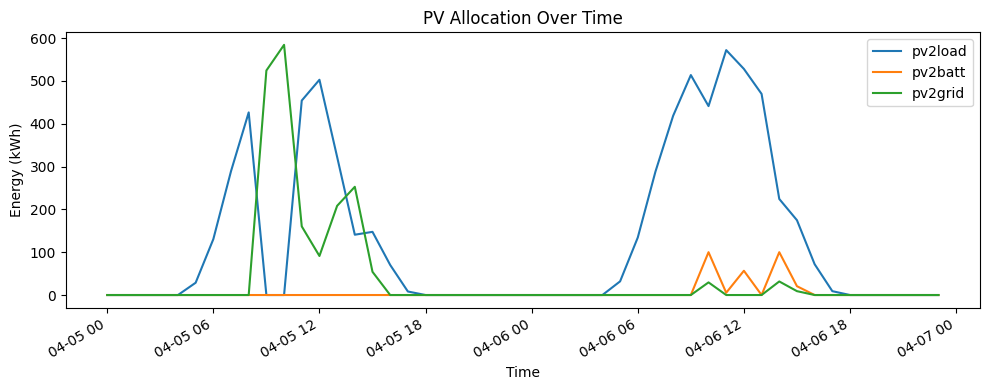

→ Writing C:\Users\Gonzalo\Desktop\Gonzalo\Profesion\CaseStudy\Hymate\Solutions\grid_allocation.jpg


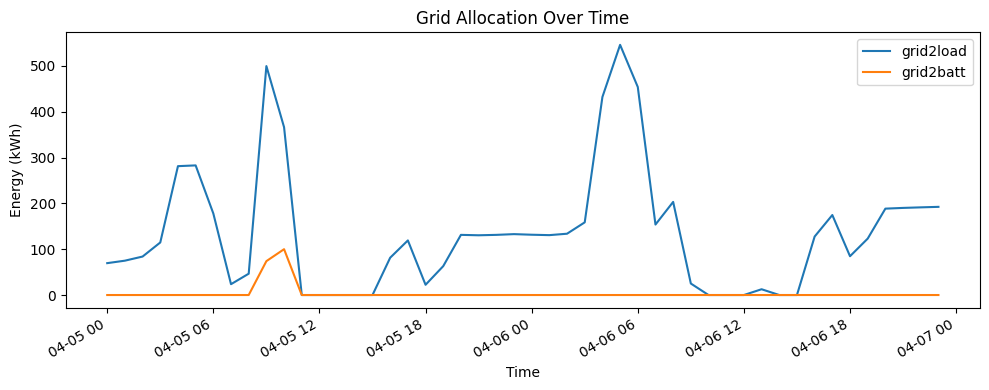

→ Writing C:\Users\Gonzalo\Desktop\Gonzalo\Profesion\CaseStudy\Hymate\Solutions\battery_discharge.jpg


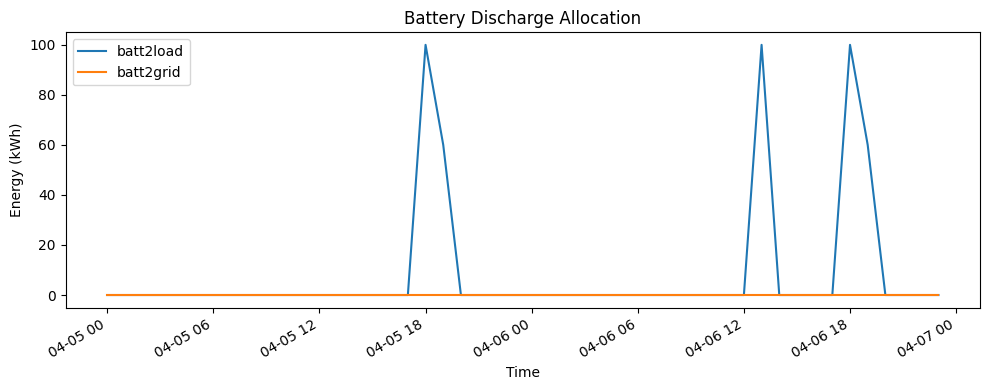

→ Writing C:\Users\Gonzalo\Desktop\Gonzalo\Profesion\CaseStudy\Hymate\Solutions\state_of_charge.jpg


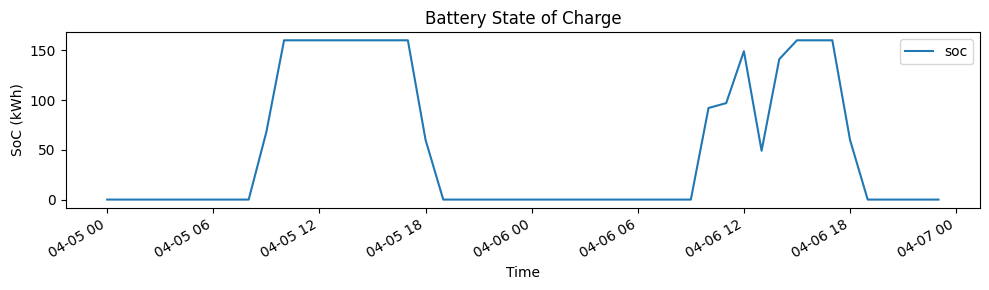

In [ ]:
#Ploting each component
# 1 Rebuild the breakdown DataFrame (unchanged)
tbl = pd.DataFrame(
    index=list(model.T),
    data={
        "pv2load":   [model.pv2load[t].value   for t in model.T],
        "pv2batt":   [model.pv2batt[t].value   for t in model.T],
        "pv2grid":   [model.pv2grid[t].value   for t in model.T],
        "grid2load": [model.grid2load[t].value for t in model.T],
        "grid2batt": [model.grid2batt[t].value for t in model.T],
        "batt2load": [model.batt2load[t].value for t in model.T],
        "batt2grid": [model.batt2grid[t].value for t in model.T],
        "soc":       [model.soc[t].value       for t in model.T],
    }
)
tbl.loc["Total"] = tbl.sum(numeric_only=True)

# 2 Determine project root & output folder
cwd = Path.cwd()
project_root = cwd.parent if cwd.name.lower() == "notebooks" else cwd
output_dir = project_root / "Solutions"
output_dir.mkdir(parents=True, exist_ok=True)

print(f"📁 Saving plots into: {output_dir.resolve()}")

# 3 Plot configurations
plot_configs = [
    (["pv2load","pv2batt","pv2grid"],   "PV Allocation Over Time",      "pv_allocation.jpg"),
    (["grid2load","grid2batt"],         "Grid Allocation Over Time",    "grid_allocation.jpg"),
    (["batt2load","batt2grid"],         "Battery Discharge Allocation", "battery_discharge.jpg"),
    (["soc"],                           "Battery State of Charge",      "state_of_charge.jpg"),
]

# 4 Generate, save, and display each plot
for cols, title, fname in plot_configs:
    fig, ax = plt.subplots(figsize=(10, 3) if cols == ["soc"] else (10, 4))
    tbl.drop(index="Total").plot(y=cols, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Time")
    ax.set_ylabel("SoC (kWh)" if cols == ["soc"] else "Energy (kWh)")
    fig.tight_layout()

    save_path = output_dir / fname
    print(f"→ Writing {save_path.resolve()}")
    fig.savefig(str(save_path), dpi=150)
    
    # Keep the graph visible in the notebook
    display(fig)
    plt.close(fig)

In [ ]:
# Saving outputs for each component
# 1) Rebuild the split‐flow & SoC table from the solved model
tbl = pd.DataFrame(index=list(model.T), data={
    'pv2load':    [model.pv2load[t].value    for t in model.T],
    'pv2batt':    [model.pv2batt[t].value    for t in model.T],
    'pv2grid':    [model.pv2grid[t].value    for t in model.T],
    'grid2load':  [model.grid2load[t].value  for t in model.T],
    'grid2batt':  [model.grid2batt[t].value  for t in model.T],
    'batt2load':  [model.batt2load[t].value  for t in model.T],
    'batt2grid':  [model.batt2grid[t].value  for t in model.T],
    'soc':        [model.soc[t].value        for t in model.T],
})

# 2) Rename columns and add PV & load
df_flow = tbl.rename(columns={
    'pv2load':   'pv to el consumption',
    'pv2batt':   'pv to battery',
    'pv2grid':   'pv to grid',
    'grid2load': 'grid to el consumption',
    'grid2batt': 'grid to battery',
    'batt2load': 'battery to el consumption',
    'batt2grid': 'battery to grid',
    'soc':       'battery state of charge',
})
df_flow['pv production, kWh'] = df['pv']
df_flow['el consumption']     = df['demand']

# 3) Reorder columns
df_flow = df_flow[[
    'pv production, kWh',
    'pv to el consumption',
    'pv to battery',
    'pv to grid',
    'battery state of charge',
    'battery to el consumption',
    'battery to grid',
    'grid to el consumption',
    'grid to battery',
    'el consumption'
]]
df_flow.index.name = 'datetime'

# 4) Display or save
display(df_flow)

,"pv production, kWh",pv to el consumption,pv to battery,pv to grid,battery state of charge,battery to el consumption,battery to grid,grid to el consumption,grid to battery,el consumption
datetime,,,,,,,,,,
2023-04-05 00:00:00,0.00000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,69.540000,0.000000,69.540000
2023-04-05 01:00:00,0.00000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,74.941647,0.000000,74.941647
2023-04-05 02:00:00,0.00000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,83.941647,0.000000,83.941647
2023-04-05 03:00:00,0.00000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,114.641650,0.000000,114.641647
2023-04-05 04:00:00,0.00000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,281.117330,0.000000,281.117334
2023-04-05 05:00:00,28.67631,28.67631,0.000000,0.000000,0.000000,0.0,0.0,282.783690,0.000000,311.460004
2023-04-05 06:00:00,130.43268,130.43268,0.000000,0.000000,0.000000,0.0,0.0,177.862320,0.000000,308.295004
2023-04-05 07:00:00,289.11611,289.11611,0.000000,0.000000,0.000000,0.0,0.0,23.648054,0.000000,312.764164
2023-04-05 08:00:00,426.35432,426.35432,0.000000,0.000000,0.000000,0.0,0.0,46.534704,0.000000,472.889024


In [ ]:
#Creating cost table
# 1) Pull split‐flows from the model
flows = pd.DataFrame(index=list(model.T), data={
    "pv2grid":    [model.pv2grid[t].value    for t in model.T],
    "grid2load":  [model.grid2load[t].value  for t in model.T],
    "grid2batt":  [model.grid2batt[t].value  for t in model.T],
    "batt2grid":  [model.batt2grid[t].value  for t in model.T],
    "batt2load":  [model.batt2load[t].value  for t in model.T],
})

# 2) Calculate costs
cost_df = pd.DataFrame(index=flows.index)
cost_df["cost buy grid→load"]    = flows["grid2load"]  * df["p_buy"]
cost_df["cost buy grid→battery"] = flows["grid2batt"]  * df["p_buy"]
cost_df["cost sell pv→grid"]     = -flows["pv2grid"]  * df["p_sell"]
cost_df["cost sell batt→grid"]   = -flows["batt2grid"]* df["p_sell"]
cost_df["cost LCOS"]             = (flows["batt2load"] + flows["batt2grid"]) * df["lcos"]
cost_df["total cash flow"]       = cost_df.sum(axis=1)

# 3) Append a total row
totals = cost_df.sum(numeric_only=True)
cost_df.loc["Total"] = totals

# 4) Label index and display
cost_df.index.name = "datetime"
display(cost_df)

,cost buy grid→load,cost buy grid→battery,cost sell pv→grid,cost sell batt→grid,cost LCOS,total cash flow
datetime,,,,,,
2023-04-05 00:00:00,17.264000,0.000000,-0.000000,-0.0,0.00,17.264000
2023-04-05 01:00:00,18.706185,0.000000,-0.000000,-0.0,0.00,18.706185
2023-04-05 02:00:00,20.838514,0.000000,-0.000000,-0.0,0.00,20.838514
2023-04-05 03:00:00,29.232474,0.000000,-0.000000,-0.0,0.00,29.232474
2023-04-05 04:00:00,74.344289,0.000000,-0.000000,-0.0,0.00,74.344289
2023-04-05 05:00:00,83.653071,0.000000,-0.000000,-0.0,0.00,83.653071
2023-04-05 06:00:00,60.103235,0.000000,-0.000000,-0.0,0.00,60.103235
2023-04-05 07:00:00,7.324748,0.000000,-0.000000,-0.0,0.00,7.324748
2023-04-05 08:00:00,12.664885,0.000000,-0.000000,-0.0,0.00,12.664885


In [22]:
# 1. Determine project root & output folder
cwd = Path.cwd()
project_root = cwd.parent if cwd.name.lower() == "notebooks" else cwd
output_dir = project_root / "Solutions"
output_dir.mkdir(parents=True, exist_ok=True)

# 2. Build the full path for the results file
output_path = output_dir / "results.xlsx"

# 3. Write both DataFrames to one Excel file
with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
    cost_df.to_excel(writer, sheet_name='Costs')
    df_flow.to_excel(writer, sheet_name='Flows')

print(f"✅ Saved results to {output_path.resolve()}")

✅ Saved results to C:\Users\Gonzalo\Desktop\Gonzalo\Profesion\CaseStudy\Hymate\Solutions\results.xlsx


📁 Saving images into: C:\Users\Gonzalo\Desktop\Gonzalo\Profesion\CaseStudy\Hymate\Solutions


KeyError: "['Total'] not found in axis"

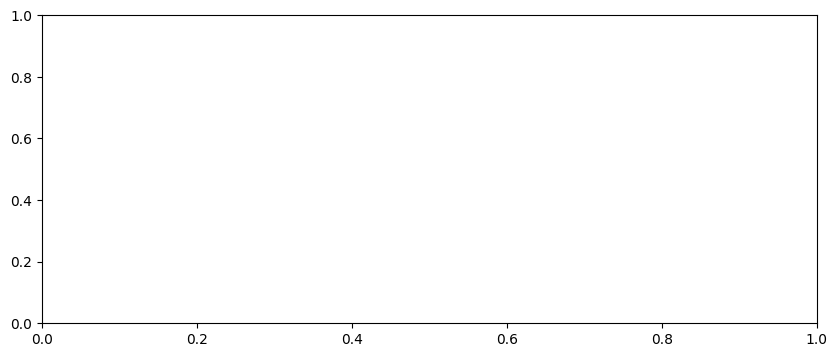